<h1>Read Input</h1>

In [186]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

train = pd.read_json("../input/train.json")

['test.json', 'sample_submission.csv', 'train.json']


In [187]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [188]:
train.head()

,audio_embedding,end_time_seconds_youtube_clip,is_turkey,start_time_seconds_youtube_clip,vid_id
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",70,0,60,kDCk3hLIVXo
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",40,1,30,DPcGzqHoo7Y
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",240,1,230,7yM63MTHh5k
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",520,1,510,luG3RmUAxxM
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",10,0,0,PIm3cjxTpOk


In [189]:
for i in range(10):
    print(len(train.audio_embedding[i]), len(train.audio_embedding[i][0]), train.end_time_seconds_youtube_clip[i] - train.start_time_seconds_youtube_clip[i])

10 128 10
10 128 10
10 128 10
10 128 10
10 128 10
10 128 10
10 128 10
10 128 10
10 128 10
10 128 10


In [190]:
train.size

5975

In [191]:
train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')
sample_submission = pd.read_csv('../input/sample_submission.csv')

train_train, train_val = train_test_split(train, random_state = 42)
xtrain = [k for k in train_train['audio_embedding']]
ytrain = train_train['is_turkey'].values

xval = [k for k in train_val['audio_embedding']]
yval = train_val['is_turkey'].values

# Pad the audio features so that all are "10 seconds" long
x_train = pad_sequences(xtrain, maxlen=10)
x_val = pad_sequences(xval, maxlen=10)

y_train = np.asarray(ytrain)
y_val = np.asarray(yval)

test_data = test['audio_embedding'].tolist()
x_test = pad_sequences(test_data, maxlen=10)

Very small amount of training data. We might need to learn a model using transfer learning over ResNet50 or something to get better metrics.

<h1>GRU

In [192]:
embed_size = 128
maxlen = 10

inp = Input(shape=(maxlen,embed_size))
x = BatchNormalization()(inp)

x = Bidirectional(GRU(128, return_sequences=True))(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
# x = Dropout(0.1)(x)
outp = Dense(1, activation='sigmoid')(x)

model_1 = Model(inputs=inp, outputs=outp)

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        (None, 10, 128)           0         
_________________________________________________________________
batch_normalization_v1_56 (B (None, 10, 128)           512       
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 10, 256)           197376    
_________________________________________________________________
bidirectional_50 (Bidirectio (None, 10, 128)           123264    
_________________________________________________________________
flatten_41 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_111 (Dense)            (None, 128)               163968    
_________________________________________________________________
dense_112 (Dense)            (None, 64)                8256      
__________

In [193]:
model_1.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

In [194]:
# history = model_1.fit(x_train, y_train,
#           batch_size=10,
#           epochs=50,
#           validation_data=(x_val, y_val))

In [195]:
# plot_history(history)

<h1>GRU with dropout

In [196]:
embed_size = 128
maxlen = 10

inp = Input(shape=(maxlen,embed_size))
x = BatchNormalization()(inp)

x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1))(x)
x = Bidirectional(GRU(64, return_sequences=True, dropout=0.1))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
outp = Dense(1, activation='sigmoid')(x)

model_2 = Model(inputs=inp, outputs=outp)

model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 10, 128)           0         
_________________________________________________________________
batch_normalization_v1_57 (B (None, 10, 128)           512       
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 10, 256)           197376    
_________________________________________________________________
bidirectional_52 (Bidirectio (None, 10, 128)           123264    
_________________________________________________________________
flatten_42 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dense_114 (Dense)            (None, 128)               163968    
_________________________________________________________________
dense_115 (Dense)            (None, 64)                8256      
__________

In [197]:
# model_2.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
# history_2 = model_2.fit(x_train, y_train,
#           batch_size=10,
#           epochs=10,
#           validation_data=(x_val, y_val))

In [198]:
# plot_history(history_2)

Accuracy graph trending up, let's try with more epochs this time

In [199]:
# history_3 = model_2.fit(x_train, y_train,
#           batch_size=10,
#           epochs=50,
#           validation_data=(x_val, y_val))
# plot_history(history_3)

<h1> CNN

In [200]:
embed_size = 128
maxlen = 10

inp = Input(shape=(maxlen,embed_size))
x = BatchNormalization()(inp)
x = Reshape((maxlen,embed_size,1))(x)

cnn_1 = Conv2D(42, kernel_size=(3, 16), kernel_initializer='he_normal', activation='tanh')(x)

cnn_2 = Conv2D(42, kernel_size=(2, 8), kernel_initializer='he_normal', activation='tanh')(cnn_1)

max_pool = GlobalMaxPooling2D()(cnn_2)
avg_pool = GlobalAveragePooling2D()(cnn_2)

concat = concatenate([max_pool, avg_pool])

x = Flatten()(concat)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.1)(x)
outp = Dense(1, activation='sigmoid')(x)

model_4 = Model(inputs=inp, outputs=outp)

model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 10, 128)      0                                            
__________________________________________________________________________________________________
batch_normalization_v1_58 (Batc (None, 10, 128)      512         input_54[0][0]                   
__________________________________________________________________________________________________
reshape_35 (Reshape)            (None, 10, 128, 1)   0           batch_normalization_v1_58[0][0]  
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 8, 113, 42)   2058        reshape_35[0][0]                 
__________________________________________________________________________________________________
conv2d_69 

In [201]:
# model_4.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
# #fit on a portion of the training data, and validate on the rest
# history_4 = model_4.fit(x_train, y_train,
#           batch_size=10,
#           epochs=20,
#           validation_data=(x_val, y_val))

In [202]:
# plot_history(history_4)

<h1>CNN + GRU

In [203]:
embed_size = 128
maxlen = 10

inp = Input(shape=(maxlen,embed_size))
x = BatchNormalization()(inp)
x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1))(x)
x = Bidirectional(GRU(64, return_sequences=True, dropout=0.1))(x)
x = Reshape((maxlen,embed_size,1))(x)

cnn_1 = Conv2D(42, kernel_size=(3, 16), kernel_initializer='he_normal', activation='tanh')(x)
cnn_2 = Conv2D(42, kernel_size=(2, 8), kernel_initializer='he_normal', activation='tanh')(cnn_1)

max_pool = GlobalMaxPooling2D()(cnn_2)
avg_pool = GlobalAveragePooling2D()(cnn_2)

concat = concatenate([max_pool, avg_pool])

x = Flatten()(concat)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outp = Dense(1, activation='sigmoid')(x)

model_5 = Model(inputs=inp, outputs=outp)

model_5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           (None, 10, 128)      0                                            
__________________________________________________________________________________________________
batch_normalization_v1_59 (Batc (None, 10, 128)      512         input_55[0][0]                   
__________________________________________________________________________________________________
bidirectional_53 (Bidirectional (None, 10, 256)      197376      batch_normalization_v1_59[0][0]  
__________________________________________________________________________________________________
bidirectional_54 (Bidirectional (None, 10, 128)      123264      bidirectional_53[0][0]           
__________________________________________________________________________________________________
reshape_36

In [204]:
model_5.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
#fit on a portion of the training data, and validate on the rest
history_5 = model_5.fit(x_train, y_train,
          batch_size=10,
          epochs=20,
          validation_data=(x_val, y_val))

In [205]:
plot_history(history_5)

<h1> CuDNNGRU

In [206]:
embed_size = 128
maxlen = 10

inp = Input(shape=(maxlen,embed_size))
x = BatchNormalization()(inp)
x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = Reshape((maxlen,embed_size,1))(x)

cnn_1 = Conv2D(42, kernel_size=(3, 16), kernel_initializer='he_normal', activation='tanh')(x)
cnn_2 = Conv2D(42, kernel_size=(2, 8), kernel_initializer='he_normal', activation='tanh')(cnn_1)

max_pool = GlobalMaxPooling2D()(cnn_2)
avg_pool = GlobalAveragePooling2D()(cnn_2)

concat = concatenate([max_pool, avg_pool])

x = Flatten()(concat)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outp = Dense(1, activation='sigmoid')(x)

model_6 = Model(inputs=inp, outputs=outp)

model_6.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           (None, 10, 128)      0                                            
__________________________________________________________________________________________________
batch_normalization_v1_60 (Batc (None, 10, 128)      512         input_56[0][0]                   
__________________________________________________________________________________________________
bidirectional_55 (Bidirectional (None, 10, 256)      198144      batch_normalization_v1_60[0][0]  
__________________________________________________________________________________________________
bidirectional_56 (Bidirectional (None, 10, 128)      123648      bidirectional_55[0][0]           
__________________________________________________________________________________________________
reshape_37

In [207]:
# model_6.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
# #fit on a portion of the training data, and validate on the rest
# history_6 = model_6.fit(x_train, y_train,
#           batch_size=10,
#           epochs=20,
#           validation_data=(x_val, y_val))

Train on 896 samples, validate on 299 samples
Epoch 1/20
896/896 [==============================] - 7s 8ms/sample - loss: 0.3523 - acc: 0.8549 - val_loss: 0.2272 - val_acc: 0.8896
Epoch 2/20
896/896 [==============================] - 1s 1ms/sample - loss: 0.1858 - acc: 0.9408 - val_loss: 0.1761 - val_acc: 0.9431
Epoch 3/20
896/896 [==============================] - 1s 1ms/sample - loss: 0.1639 - acc: 0.9531 - val_loss: 0.1970 - val_acc: 0.9231
Epoch 4/20
896/896 [==============================] - 1s 1ms/sample - loss: 0.0975 - acc: 0.9732 - val_loss: 0.2320 - val_acc: 0.9164
Epoch 5/20
896/896 [==============================] - 1s 1ms/sample - loss: 0.0825 - acc: 0.9788 - val_loss: 0.2362 - val_acc: 0.9030
Epoch 6/20
896/896 [==============================] - 1s 1ms/sample - loss: 0.1141 - acc: 0.9654 - val_loss: 0.2023 - val_acc: 0.9264
Epoch 7/20
896/896 [==============================] - 1s 1ms/sample - loss: 0.0790 - acc: 0.9777 - val_loss: 0.2074 - val_acc: 0.9365
Epoch 8/20
896/8

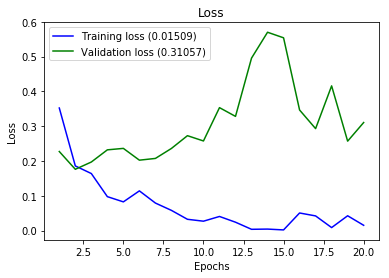

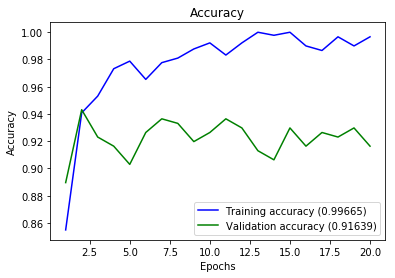

In [208]:
# plot_history(history_6)

<h1>Submission

In [209]:
y_test = model_5.predict(x_test)

In [210]:
submission = pd.DataFrame({'vid_id': test['vid_id'].values, 'is_turkey': list(y_test.flatten())})
submission.head(20)

,vid_id,is_turkey
0,pyKh38FXD3E,0.000000
1,THhP1idrWXA,0.000000
2,jsw3T6GY2Nw,0.000091
3,nFkXTMHcjMU,0.000000
4,Au8g9kAlrLQ,0.999956
5,tgk3DUpRI-w,0.000008
6,BczNwyCGlH4,0.074837
7,zB5eXpmJDTM,0.000000
8,099z8epFcfc,1.000000
9,lQ8DMnq415o,1.000000


In [ ]:
submission.to_csv("submission.csv", index=False)